# Web Scrapping

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time

def scrape_forum_posts(start_page, posts_needed, output_file):
    # Base configuration
    base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'
    accumulated_posts = []
    current_page = start_page

    while len(accumulated_posts) < posts_needed:
        response = requests.get(base_url.format(current_page))
        if response.status_code != 200:
            print(f"Failed to fetch data on page {current_page}")
            break

        # Parse the page content and add new comments
        soup = BeautifulSoup(response.text, 'html.parser')
        comments = parse_comments(soup)
        accumulated_posts.extend(comments)

        # Stop when we have the desired about of forum posts
        if len(accumulated_posts) >= posts_needed:
            accumulated_posts = accumulated_posts[:posts_needed]
            break

        current_page -= 1

         # Add delay to avoid overwhelming the server
        time.sleep(0.5)

    # Save results to a CSV file
    save_to_csv(accumulated_posts, output_file)

def parse_comments(soup):
    # Extract comment details within the page
    comments_block = soup.find_all('div', class_='Comment')
    comments_data = []

    for comment in comments_block:
        message_element = comment.find('div', class_='Message userContent')

        # Clean up the data
        message = message_element.text.strip() if message_element else 'No message available'
        comments_data.append([message])

    return comments_data

def save_to_csv(posts, filename):
    # Save the data into a CSV file
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['message'])
        writer.writerows(posts)
    print(f"Data successfully saved to {filename}")

if __name__ == "__main__":
    PAGE_START = 435
    POST_COUNT = 5000
    FILE_NAME = 'Edmunds_forum_posts.csv'

    # Run the scraper
    scrape_forum_posts(PAGE_START, POST_COUNT, FILE_NAME)

Data successfully saved to Edmunds_forum_posts.csv


In [ ]:
from google.colab import files
files.download("Edmunds_forum_posts.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
#import all the necessary libraries
import pandas as pd
import nltk
from nltk.corpus import reuters, wordnet, stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#import the file - just keep the tweets/ the conversations/post - one post per row- we do not need the date or the user name for now
from google.colab import files

uploaded = files.upload()

Saving Edmunds_forum_posts.csv to Edmunds_forum_posts (1).csv


In [4]:
df = pd.read_csv("Edmunds_forum_posts.csv")
df = df.rename(columns={'message': 'Tweet'})

In [5]:
df.head()

,Tweet
0,benjaminh said: Michaell said: dino001 said:BT...
1,Add $350 to any lease on a Kia if you are not ...
2,benjaminh said: roadburner said:I'm still givi...
3,That's a jaw-dropping lease incentive. Amazing...
4,"andres3 said:Also, by the way, the $400 dispos..."


# Zipf's Law Verification
We have all the stopwords and the models are not yet replaced by brands



*   interpret coefficient of log rank
*   interpret the p-value
*   interpret the residuals (actual vs. theoretical prediction of the law)


In [6]:
#verify zipf's law with bag of words - stopwords are kept as it is - models are not yet replaced with brands and stop words still exist
def get_words(text): # define a function to get all words in that tweet or comment
  return [word for word in re.split(r"[^\w'-]+", str(text).lower()) if word.strip()]

df['Tweet'] = df['Tweet'].apply(lambda tweet: tweet.lower() if isinstance(tweet, str) else tweet)
df['all_words'] = df['Tweet'].apply(get_words)
bag_of_words = [word for words_list in df['all_words'] for word in words_list]

bag_of_words_count = Counter(bag_of_words)

bag_of_words_count_df = pd.DataFrame(bag_of_words_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
bag_of_words_count_df['rank'] = bag_of_words_count_df['count'].rank(method='min', ascending=False)

csv_file_path = 'bag_of_words.csv'
bag_of_words_count_df.to_csv(csv_file_path, index=False)

#from google.colab import files
#files.download(csv_file_path)

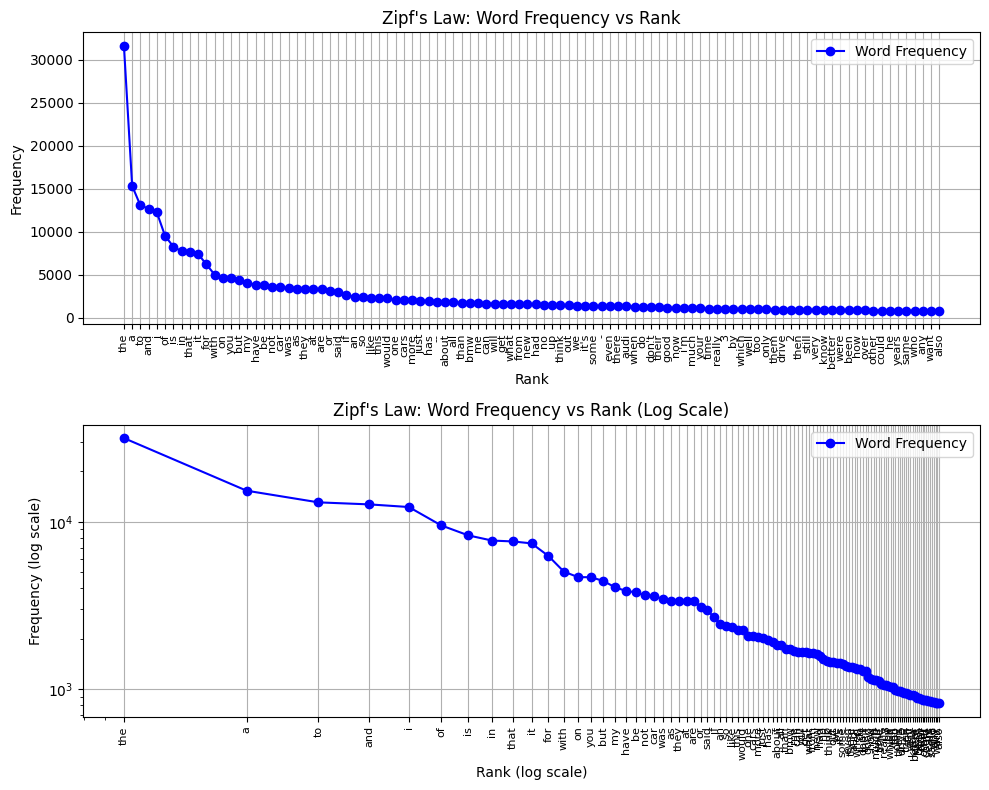

In [7]:
bag_of_words_count_df['rank'] = bag_of_words_count_df['count'].rank(method='first', ascending=False)
top_100_df = bag_of_words_count_df.nsmallest(100, 'rank')
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8 ))

# Plot 1: Word Frequency vs Rank (normal scale)
ax1.plot(top_100_df['rank'], top_100_df['count'], marker='o', linestyle='-', color='b', label='Word Frequency')
ax1.set_title("Zipf's Law: Word Frequency vs Rank")
ax1.set_xlabel('Rank')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True)

# Set the x-ticks as the words
ax1.set_xticks(top_100_df['rank'])
ax1.set_xticklabels(top_100_df['word'], rotation=90, fontsize=8)

# Plot 2: Word Frequency vs Rank with y = 1/x and y = 1/x^2 (log scale)
x_vals = top_100_df['rank']
y_1_over_x = 1 / x_vals
y_1_over_x2 = 1 / (x_vals ** 2)

ax2.plot(x_vals, top_100_df['count'], marker='o', linestyle='-', color='b', label='Word Frequency')

# Set log scale for both axes
ax2.set_xscale('log')
ax2.set_yscale('log')

# Add labels and title to the second plot
ax2.set_title("Zipf's Law: Word Frequency vs Rank (Log Scale)")
ax2.set_xlabel('Rank (log scale)')
ax2.set_ylabel('Frequency (log scale)')
ax2.legend()
ax2.grid(True)

ax2.set_xticks(top_100_df['rank'])
ax2.set_xticklabels(top_100_df['word'], rotation=90, fontsize=8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

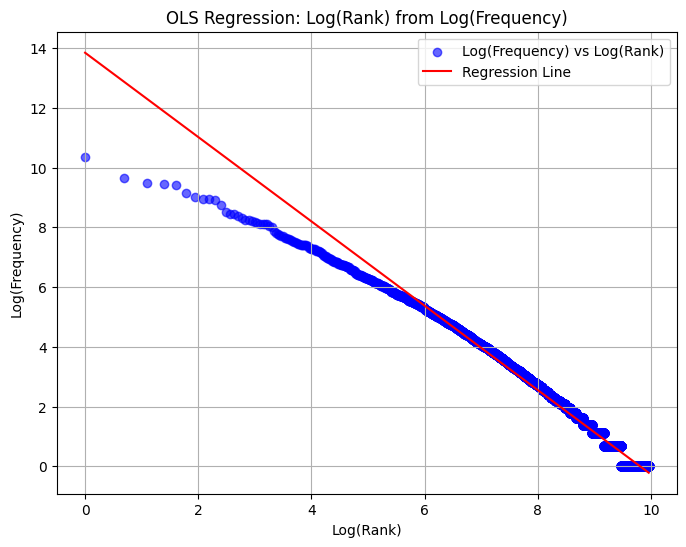

Slope (coefficient): -1.4119437551033136
Intercept: 13.846917743865996
Standard Error: 0.0013274421428784236
                            OLS Regression Results                            
Dep. Variable:          log_frequency   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.131e+06
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:39:03   Log-Likelihood:                 4807.1
No. Observations:               21150   AIC:                            -9610.
Df Residuals:                   21148   BIC:                            -9594.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  # Importing statsmodels

# Log transformation for rank and frequency
bag_of_words_count_df['log_rank'] = np.log(bag_of_words_count_df['rank'])
bag_of_words_count_df['log_frequency'] = np.log(bag_of_words_count_df['count'])

# Prepare data for regression
X = bag_of_words_count_df['log_rank']    # Feature (log frequency)
y = bag_of_words_count_df['log_frequency'] # Target (log rank)

# Add a constant (intercept) to X
X_with_const = sm.add_constant(X)  # Adds a column for the intercept term

# Perform OLS regression using statsmodels
model = sm.OLS(y, X_with_const).fit()

# Get the predictions
y_pred = model.predict(X_with_const)

# Plot the data and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Log(Frequency) vs Log(Rank)', alpha=0.6)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.title('OLS Regression: Log(Rank) from Log(Frequency)')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, intercept, and standard error of the regression line
slope = model.params[1]  # Slope (coefficient of log_frequency)
intercept = model.params[0]  # Intercept
standard_error = model.bse[1]  # Standard error of the slope (log_frequency)

# Output the results
print(f"Slope (coefficient): {slope}")
print(f"Intercept: {intercept}")
print(f"Standard Error: {standard_error}")

# Optional: print full model summary
print(model.summary())

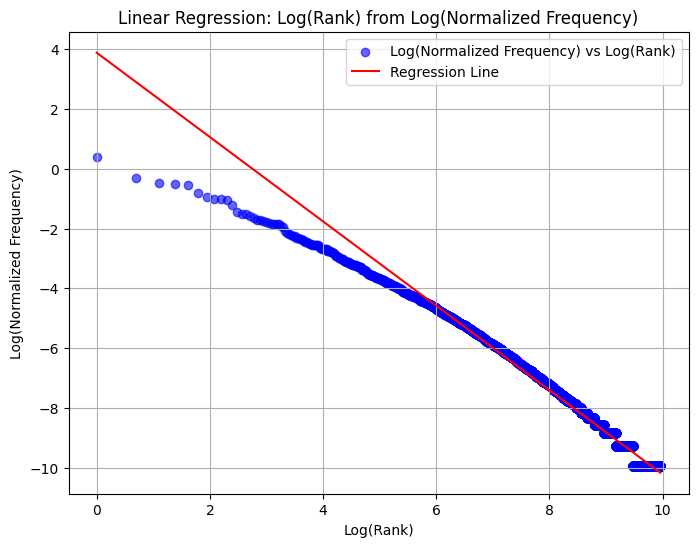

Slope (coefficient): -1.411943755103313
Intercept: 3.8875225593915643
Standard Error: 0.0013274421428784231


In [9]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Get the last element's rank (n) and its frequency (frequency(n))
n = bag_of_words_count_df['rank'].iloc[-1]
freq_n = bag_of_words_count_df['count'].iloc[-1]

# Calculate frequency / (n * frequency(n))
constant = n * freq_n
bag_of_words_count_df['normalized_frequency'] = bag_of_words_count_df['count'] / constant

# Take the log of rank and the normalized frequency
bag_of_words_count_df['log_rank'] = np.log(bag_of_words_count_df['rank'])
bag_of_words_count_df['log_normalized_frequency'] = np.log(bag_of_words_count_df['normalized_frequency'])

# Prepare data for regression
X = bag_of_words_count_df['log_rank']   # Feature (log(normalized frequency))
y = bag_of_words_count_df['log_normalized_frequency']# Target (log rank)

# Add a constant (intercept) to the X variable for statsmodels OLS
X_with_const = sm.add_constant(X)  # Adds the intercept term

# Fit the model using OLS from statsmodels
model = sm.OLS(y, X_with_const).fit()

# Get the predictions
y_pred = model.predict(X_with_const)

# Plot the data and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Log(Normalized Frequency) vs Log(Rank)', alpha=0.6)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.title('Linear Regression: Log(Rank) from Log(Normalized Frequency)')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Normalized Frequency)')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, intercept, and standard error of the regression line
slope = model.params[1]  # Slope (coefficient of log_normalized_frequency)
intercept = model.params[0]  # Intercept
standard_error = model.bse[1]  # Standard error of the slope (log_normalized_frequency)

# Output the results
print(f"Slope (coefficient): {slope}")
print(f"Intercept: {intercept}")
print(f"Standard Error: {standard_error}")


# Econometrically Testing Zipf's law

In [10]:
from scipy import stats
t_stat = (slope - (-1)) / standard_error
# Degrees of freedom (n - number of parameters)
degrees_of_freedom = model.df_resid  # Residual degrees of freedom

# Calculate the two-tailed p-value using the t-distribution
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=degrees_of_freedom))

# Print the results
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The coefficient is significantly different from -1.")
else:
    print("Fail to reject the null hypothesis: The coefficient is not significantly different from -1.")

P-value: 0.0
Reject the null hypothesis: The coefficient is significantly different from -1.


We get Theta and Beta value = -0.69, which are statistically significant from -1. Therefore the given dataset does not support Zipf's law econometrically

## Getting rid of stop words and getting the count

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [18]:
import nltk
print(nltk.data.path)






['/Users/dameliaziken/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.10/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.10/share/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.10/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/path/to/your/nltk_data']


In [13]:
#calculating frequencies without the stopwords - easy to go through the list
nltk.download('punkt')
nltk.download('stopwords')
# Load the stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords and tokenize
def remove_stopwords_and_tokenize(text):
    # Handle non-string (float or NaN) values by converting them to empty strings
    if not isinstance(text, str):
        text = ''

    # Preprocess: Replace hyphens between words with underscores to preserve hyphenated words
    text = re.sub(r'\b(\w+)-(\w+)\b', r'\1_\2', text.lower())  # Convert text to lowercase and replace hyphenated words

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and non-alphabetic tokens (while treating underscores as part of the word)
    filtered_tokens = [word for word in tokens if word.isalpha() or '_' in word]

    # Remove stopwords
    filtered_tokens = [word for word in filtered_tokens if word not in stop_words]

    return filtered_tokens

# Apply the function to the posts column
df['filtered_words'] = df['Tweet'].apply(remove_stopwords_and_tokenize)

# Get all words into a single list
all_words = [word for words_list in df['filtered_words'] for word in words_list]

# Get the overall word count
word_count = Counter(all_words)

word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
print(word_count_df)

csv_file_path = 'word_frequencies.csv'
word_count_df.to_csv(csv_file_path, index=False)

#from google.colab import files
#files.download(csv_file_path)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/dameliaziken/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


# Get the mapping file and replace Model with brand - get top 10 brands

In [ ]:
#get the mapping file
from google.colab import drive
from google.colab import files
uploaded = files.upload()

Saving car_models_and_brands.csv to car_models_and_brands.csv


In [ ]:
brands = pd.read_csv("car_models_and_brands.csv")
# Drop duplicates
brands = brands.drop_duplicates(subset='Model')
brands=brands[brands['Model']!='mercedes']
brands

,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx
...,...,...
525,volvo,xc90
526,volvo,s60
527,volvo,s80
528,volvo,v60


In [ ]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.9 MB/s eta 0:00:00


## Cleaning up the mapping file

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re
known_brands = ['toyota', 'honda', 'ford', 'chevrolet', 'bmw', 'mercedes', 'audi',
                'volkswagen', 'nissan', 'hyundai', 'kia', 'mazda', 'subaru', 'lexus',
                'acura', 'infiniti', 'volvo', 'jaguar', 'land rover', 'porsche', 'ferrari',
                'lamborghini', 'maserati', 'alfa romeo', 'fiat', 'jeep', 'chrysler', 'dodge',
                'ram', 'buick', 'cadillac', 'gmc', 'lincoln', 'tesla', 'mini', 'mitsubishi', 'genesis',
                'bentley', 'rolls-royce', 'aston martin', 'pontiac', 'saturn', 'suzuki']

def clean_text(text):
    # Replace special characters with space and trim
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return ' '.join(text.split()).strip()

def preprocess_brands(car_data, known_brands, similarity_threshold=80):
    # Convert brand names to lowercase and clean
    car_data['Brand'] = car_data['Brand'].str.lower().apply(clean_text)
    # Clean known brands
    known_brands = [clean_text(brand.lower()) for brand in known_brands]

    # Group similar brand names
    brand_mapping = {}
    for brand in car_data['Brand'].unique():
        if brand not in brand_mapping:
            matches = process.extract(brand, known_brands, limit=1, scorer=fuzz.ratio)
            if matches and matches[0][1] >= similarity_threshold:
                brand_mapping[brand] = matches[0][0]
            else:
                brand_mapping[brand] = brand

    # Apply the mapping to the DataFrame
    car_data['Brand_new'] = car_data['Brand'].map(brand_mapping)

    return car_data

car_data = preprocess_brands(brands, known_brands)

# Corner-case
car_data['Brand_new'].replace({'mercedes benz': 'mercedes'}, inplace = True)

# Filter non-brand words out
car_data = car_data[car_data['Brand_new'].isin(known_brands)]
car_data = car_data.drop(columns = 'Brand')
car_data.rename(columns={'Brand_new': 'Brand'}, inplace=True)
# New row to add
new_row = {'Brand': 'cadillac', 'Model': 'cts'}

car_data.loc[len(df)] = new_row
car_data

,Model,Brand
0,integra,acura
1,legend,acura
2,vigor,acura
3,rlx,acura
4,ilx,acura
...,...,...
526,s60,volvo
527,s80,volvo
528,v60,volvo
529,c70,volvo


In [ ]:
# Create dictionary where 'brand' is the key and 'model' is the value
brand_model_dict = car_data.set_index('Model')['Brand'].to_dict()
brand_model_dict = dict(zip(brands['Model'], brands['Brand']))
print(brand_model_dict)

{'integra': 'acura', 'legend': 'acura', 'vigor': 'acura', 'rlx': 'acura', 'ilx': 'acura', 'mdx': 'acura', 'rdx': 'acura', 'tsx': 'acura', 'rsx': 'acura', 'quattro': 'audi', 'a4': 'audi', 'a6': 'audi', 'a5': 'audi', 'a7': 'audi', 'q3': 'audi', 'q5': 'audi', 'q7': 'audi', 'a8': 'audi', 'a3': 'audi', '3-series': 'bmw', '5-series': 'bmw', '6-series': 'bmw', '4-series': 'bmw', 'xdrive': 'bmw', 'alpina': 'bmw', '330ci': 'bmw', '328i': 'bmw', '330c': 'bmw', '335i': 'bmw', '335d': 'bmw', '528i': 'bmw', '535i': 'bmw', '128i': 'bmw', '640i': 'bmw', '3er': 'bmw', '5er': 'bmw', 'm5': 'bmw', 'm3': 'bmw', 'm6': 'bmw', 'bmws': 'bmw', 'bmwesque': 'bmw', 'park avenue': 'buick', 'la crosse': 'buick', 'lacrosse': 'buick', 'century': 'buick', 'enclave': 'buick', 'encore': 'buick', 'regal': 'buick', 'buicks': 'buick', 'escalade': 'cadillac', 'srx': 'cadillac', 'xts': 'cadillac', 'cars': 'car', 'grand blazer': 'chevrolet', 'trailblazer': 'chevrolet', 'silverado': 'chevrolet', 'colorado': 'chevrolet', 'corve

In [ ]:
#replace model with brands
import copy
def replace_model_with_brand(tweet):
    model_to_brand_dict = brand_model_dict
    # Iterate over the model-brand dictionary
    for model, brand in model_to_brand_dict.items():
        # Use regex to replace model names with brand names, ignoring case
        tweet = re.sub(r'\b{}\b'.format(re.escape(model)), brand, tweet, flags=re.IGNORECASE)
    return tweet

new_sample_data = copy.deepcopy(df)
new_sample_data['Tweet'] = new_sample_data['Tweet'].fillna('')
new_sample_data['new_Tweet'] = new_sample_data['Tweet'].apply(replace_model_with_brand)
new_sample_data

,Tweet,all_words,filtered_words,new_Tweet
0,benjaminh said: michaell said: dino001 said:bt...,"[benjaminh, said, michaell, said, dino001, sai...","[benjaminh, said, michaell, said, said, btw, l...",benjaminh said: michaell said: dino001 said:bt...
1,add $350 to any lease on a kia if you are not ...,"[add, 350, to, any, lease, on, a, kia, if, you...","[add, lease, kia, buying, due, key, fob, scam,...",add $350 to any lease on a kia if you are not ...
2,benjaminh said: roadburner said:i'm still givi...,"[benjaminh, said, roadburner, said, i'm, still...","[benjaminh, said, roadburner, said, still, giv...",benjaminh said: roadburner said:i'm still givi...
3,that's a jaw-dropping lease incentive. amazing...,"[that's, a, jaw-dropping, lease, incentive, am...","[jaw_dropping, lease, incentive, amazing, mf, ...",that's a jaw-dropping lease incentive. amazing...
4,"andres3 said:also, by the way, the $400 dispos...","[andres3, said, also, by, the, way, the, 400, ...","[said, also, way, disposition, fee, waived, bu...","andres3 said:also, by the way, the $400 dispos..."
...,...,...,...,...
4995,sounds like upside down on a crap car plus poo...,"[sounds, like, upside, down, on, a, crap, car,...","[sounds, like, upside, crap, car, plus, poor, ...",sounds like upside down on a crap car plus poo...
4996,@stickguy said:\nwhich lexus model is this?\n\...,"[stickguy, said, which, lexus, model, is, this...","[stickguy, said, lexus, model, gon, na, sit, b...",@stickguy said:\nwhich lexus model is this?\n\...
4997,@markcincinnati - like i mentioned i got the 1...,"[markcincinnati, -, like, i, mentioned, i, got...","[markcincinnati, like, mentioned, got, mine, s...",@markcincinnati - like i mentioned i got the 1...
4998,@stickguy i like the new feature to add pix- b...,"[stickguy, i, like, the, new, feature, to, add...","[stickguy, like, new, feature, add, badges, re...",@stickguy i like the new feature to add pix- b...


In [ ]:
new_sample_data['filtered_words_brand_level']=new_sample_data['new_Tweet'].apply(remove_stopwords_and_tokenize)
new_sample_data

,Tweet,all_words,filtered_words,new_Tweet,filtered_words_brand_level
0,benjaminh said: michaell said: dino001 said:bt...,"[benjaminh, said, michaell, said, dino001, sai...","[benjaminh, said, michaell, said, said, btw, l...",benjaminh said: michaell said: dino001 said:bt...,"[benjaminh, said, michaell, said, said, btw, l..."
1,add $350 to any lease on a kia if you are not ...,"[add, 350, to, any, lease, on, a, kia, if, you...","[add, lease, kia, buying, due, key, fob, scam,...",add $350 to any lease on a kia if you are not ...,"[add, lease, kia, buying, due, key, fob, scam,..."
2,benjaminh said: roadburner said:i'm still givi...,"[benjaminh, said, roadburner, said, i'm, still...","[benjaminh, said, roadburner, said, still, giv...",benjaminh said: roadburner said:i'm still givi...,"[benjaminh, said, roadburner, said, still, giv..."
3,that's a jaw-dropping lease incentive. amazing...,"[that's, a, jaw-dropping, lease, incentive, am...","[jaw_dropping, lease, incentive, amazing, mf, ...",that's a jaw-dropping lease incentive. amazing...,"[jaw_dropping, lease, incentive, amazing, mf, ..."
4,"andres3 said:also, by the way, the $400 dispos...","[andres3, said, also, by, the, way, the, 400, ...","[said, also, way, disposition, fee, waived, bu...","andres3 said:also, by the way, the $400 dispos...","[said, also, way, disposition, fee, waived, bu..."
...,...,...,...,...,...
4995,sounds like upside down on a crap car plus poo...,"[sounds, like, upside, down, on, a, crap, car,...","[sounds, like, upside, crap, car, plus, poor, ...",sounds like upside down on a crap car plus poo...,"[sounds, like, upside, crap, car, plus, poor, ..."
4996,@stickguy said:\nwhich lexus model is this?\n\...,"[stickguy, said, which, lexus, model, is, this...","[stickguy, said, lexus, model, gon, na, sit, b...",@stickguy said:\nwhich lexus model is this?\n\...,"[stickguy, said, lexus, model, gon, na, sit, b..."
4997,@markcincinnati - like i mentioned i got the 1...,"[markcincinnati, -, like, i, mentioned, i, got...","[markcincinnati, like, mentioned, got, mine, s...",@markcincinnati - like i mentioned i got the 1...,"[markcincinnati, like, mentioned, got, mine, s..."
4998,@stickguy i like the new feature to add pix- b...,"[stickguy, i, like, the, new, feature, to, add...","[stickguy, like, new, feature, add, badges, re...",@stickguy i like the new feature to add pix- b...,"[stickguy, like, new, feature, add, badges, re..."


In [ ]:
#pure brand frequency
def unique_words(s):
  return list(set(s))

new_sample_data['filtered_words_brands'] = new_sample_data['new_Tweet'].apply(remove_stopwords_and_tokenize)
new_sample_data['unique_words']=new_sample_data['filtered_words_brands'].apply(unique_words)
all_words_brands = [word for words_list in new_sample_data['unique_words'] for word in words_list]

#get normal count - multiple occurances are not treated as 1
all_words_normal = [word for words_list in new_sample_data['filtered_words_brand_level'] for word in words_list]
word_count = Counter(all_words_normal)
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
print(word_count_df)

csv_file_path = 'word_frequencies_brand_normal.csv'
# Save it directly to the local file system
word_count_df.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

# Get the overall word count just for unique number of tweets having that word (multiple occuarance counted as 1)
word_count = Counter(all_words_brands)
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
print(word_count_df)
csv_file_path = 'word_frequencies_brand_unique.csv'
# Save it directly to the local file system
word_count_df.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

            word  count
83           car   5654
1           said   2961
177          bmw   2591
223         audi   2573
79         would   2481
...          ...    ...
6650   usability      1
6653     boasted      1
6655   congrates      1
12262    borrows      1
17074     resets      1

[17075 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

               word  count
106             car   2306
10             said   2094
109            like   1512
138           would   1390
352             one   1361
...             ...    ...
10619       collude      1
10617  poster_child      1
10616           ssd      1
1735      high_lift      1
17074     monitored      1

[17075 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
filtered_word_freq_df = word_count_df[word_count_df['word'].isin(car_data['Brand'].str.lower())]
filtered_word_freq_df = filtered_word_freq_df[ (filtered_word_freq_df['word'] != 'car') & (filtered_word_freq_df['word'] != 'sedan') ]

# Get the top 10 brands
top_10 = filtered_word_freq_df.sort_values(by='count', ascending=False)[:10]

#Write only the words (brands) to a text file
with open('pair_keys.txt', 'w') as f:
    for word in top_10['word']:
        f.write(f"{word}\n")

In [ ]:
top_10

,word,count
186,bmw,1271
210,audi,954
227,acura,604
217,honda,514
358,volkswagen,301
203,mercedes,287
209,infiniti,271
204,cadillac,252
768,toyota,245
74,hyundai,243


In [ ]:
from google.colab import drive
from google.colab import files
uploaded = files.upload()

Saving top_attributes.csv to top_attributes.csv


In [ ]:
#getting the top attributes
top_attributes = pd.read_csv("top_attributes.csv")
top_at = top_attributes['Attributes'].unique()
top_at

array(['price', 'performance', 'luxury', 'engine', 'seat'], dtype=object)

In [ ]:
#looking at the top brands
top_br = top_10['word'].unique()
top_br

array(['bmw', 'audi', 'acura', 'honda', 'volkswagen', 'mercedes',
       'infiniti', 'cadillac', 'toyota', 'hyundai'], dtype=object)

In [ ]:
#occarance counter
def count_words(word,s):
  c=0
  for i in s:
    if word == i:
      c=c+1
  return c

In [ ]:
#brand occurance counter
br_oc = {}
for i in top_br:
  br_oc[i] = count_words(i,all_words_brands)

br_oc

{'bmw': 1271,
 'audi': 954,
 'acura': 604,
 'honda': 514,
 'volkswagen': 301,
 'mercedes': 287,
 'infiniti': 271,
 'cadillac': 252,
 'toyota': 245,
 'hyundai': 243}

In [ ]:
#attribute occurance counter
at_oc = {}
for i in top_at:
  at_oc[i] = count_words(i,all_words_brands)

at_oc

{'price': 565, 'performance': 371, 'luxury': 367, 'engine': 363, 'seat': 317}

In [ ]:
all_tweets = list(new_sample_data['new_Tweet'])
all_tweets

['benjaminh said: michaell said: dino001 said:btw, i looked into incentives on stinger. up to 9.5 grand, but only if you take the specific lease through a captive program (24 month for the highest rebate) plus 1.5k conquest and whatever else may come, which can still be a great deal, considering the residual will likely be inflated vs. real value. that\'s insane. i think they overproduced big time, especially those "gt+" models.\n$12,200 lease cash for 24 months on gt2 awd.6 trim levels have lease cash at or above $10k for 24 month terms.many, many people are "leasing", then immediately buying out the lease.\nthat\'s a jaw-dropping lease incentive. amazing deal. \nand, that\'s on top of any discount you negotiate off the msrp.however, the 24/10 residual on the aforementioned gt2 awd is only 51%, and the mf is .00191, or 4.58%.the gt2 stickers for north of $50k, iirc.',
 "add $350 to any lease on a kia if you are not buying it out due to the key fob scam. also, by the way, the $400 disp

In [ ]:
def count_words_between(text, word1, word2):
    # Convert the text to string, if it's not already, and handle missing values
    if isinstance(text, float):
        return None  # Return None or any appropriate value for NaN or float entries

    words = str(text).split()  # Ensure text is a string and then split into words
    positions_word1 = [i for i, word in enumerate(words) if word == word1]  # Positions of word1
    positions_word2 = [i for i, word in enumerate(words) if word == word2]  # Positions of word2

    if not positions_word1 or not positions_word2:
        return None  # Return None if either word is not found in the text

    # Calculate the minimum distance between word1 and word2
    min_distance = min(abs(pos1 - pos2) for pos1 in positions_word1 for pos2 in positions_word2)
    return min_distance

In [ ]:
def count_texts_with_distance(texts, word1, word2, max_distance):
    count = 0

    for text in texts:
        distance = count_words_between(text, word1, word2)
        if distance is not None and distance <= max_distance:
            count += 1

    return count

In [ ]:
def lift_matrix_final(l1,l2,all_tweets,max_dist):
  n_tweets = len(all_tweets)
  lift_matrix = pd.DataFrame(np.zeros((len(l1), len(l2))), index=l1, columns=l2)
  for i in l1:
    for j in l2:
        if i == j:
            lift_matrix.loc[i, j] = 1  # Same brand, lift is 1
        else:
            if l1[i] != 0 and l2[j] != 0:
                # Calculate lift (using a placeholder formula for this example)
                print(i,",",j,":",count_texts_with_distance(all_tweets,i,j,max_dist))
                lift_matrix.loc[i, j] = n_tweets*count_texts_with_distance(all_tweets,i,j,max_dist)/(l1[i]*l2[j])
            else:
                lift_matrix.loc[i, j] = 0  # Avoid division by zero
  return lift_matrix

brand_lift = lift_matrix_final(br_oc,br_oc,all_tweets,7)
# Display the lift matrix
print(brand_lift)

bmw , audi : 88
bmw , acura : 22
bmw , honda : 20
bmw , volkswagen : 4
bmw , mercedes : 50
bmw , infiniti : 13
bmw , cadillac : 11
bmw , toyota : 7
bmw , hyundai : 14
audi , bmw : 88
audi , acura : 34
audi , honda : 18
audi , volkswagen : 36
audi , mercedes : 20
audi , infiniti : 29
audi , cadillac : 12
audi , toyota : 6
audi , hyundai : 13
acura , bmw : 22
acura , audi : 34
acura , honda : 57
acura , volkswagen : 0
acura , mercedes : 4
acura , infiniti : 37
acura , cadillac : 12
acura , toyota : 3
acura , hyundai : 4
honda , bmw : 20
honda , audi : 18
honda , acura : 57
honda , volkswagen : 5
honda , mercedes : 0
honda , infiniti : 1
honda , cadillac : 0
honda , toyota : 17
honda , hyundai : 8
volkswagen , bmw : 4
volkswagen , audi : 36
volkswagen , acura : 0
volkswagen , honda : 5
volkswagen , mercedes : 3
volkswagen , infiniti : 2
volkswagen , cadillac : 2
volkswagen , toyota : 5
volkswagen , hyundai : 7
mercedes , bmw : 50
mercedes , audi : 20
mercedes , acura : 4
mercedes , honda 

In [ ]:
#get the inverse lift matrix
inverse_lift_matrix = brand_lift.applymap(lambda x: 1/x if x != 0 else 1/0.3)
# Set diagonal elements to 0
np.fill_diagonal(inverse_lift_matrix.values, 0)
inverse_lift_matrix

<ipython-input-35-630f2b26a674>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inverse_lift_matrix = brand_lift.applymap(lambda x: 1/x if x != 0 else 1/0.3)


,bmw,audi,acura,honda,volkswagen,mercedes,infiniti,cadillac,toyota,hyundai
bmw,0.000000,2.755759,6.978945,6.532940,19.128550,1.459108,5.299092,5.823491,8.897000,4.412186
audi,2.755759,0.000000,3.389506,5.448400,1.595300,2.737980,1.782993,4.006800,7.791000,3.566492
acura,6.978945,3.389506,0.000000,1.089319,3.333333,8.667400,0.884778,2.536800,9.865333,7.338600
honda,6.532940,5.448400,1.089319,0.000000,6.188560,3.333333,27.858800,3.333333,1.481529,3.122550
volkswagen,19.128550,1.595300,3.333333,6.188560,0.000000,5.759133,8.157100,7.585200,2.949800,2.089800
mercedes,1.459108,2.737980,8.667400,3.333333,5.759133,0.000000,3.888850,2.892960,3.333333,3.487050
infiniti,5.299092,1.782993,0.884778,27.858800,8.157100,3.888850,0.000000,1.707300,13.279000,13.170600
cadillac,5.823491,4.006800,2.536800,3.333333,7.585200,2.892960,1.707300,0.000000,3.333333,6.123600
toyota,8.897000,7.791000,9.865333,1.481529,2.949800,3.333333,13.279000,3.333333,0.000000,1.701000
hyundai,4.412186,3.566492,7.338600,3.122550,2.089800,3.487050,13.170600,6.123600,1.701000,0.000000


# Brand MDS

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


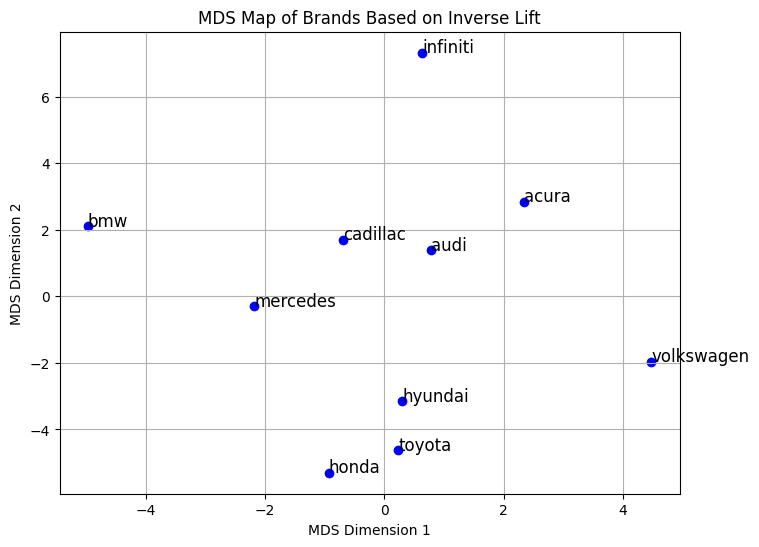

In [ ]:
#create a MDS map for the brands
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=50)
mds_coordinates = mds.fit_transform(inverse_lift_matrix)

# Create a scatter plot of the MDS map
plt.figure(figsize=(8, 6))
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], color='blue')

# Annotate points with brand names
for i, brand in enumerate(top_br):
    plt.text(mds_coordinates[i, 0], mds_coordinates[i, 1], brand, fontsize=12)

plt.title("MDS Map of Brands Based on Inverse Lift")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()

# Analysis : ???????

# Attributes & Brands Lift

In [ ]:
#attribute brand lift
attribute_brand_lift = lift_matrix_final(br_oc,at_oc,all_tweets,7)
attribute_brand_lift

bmw , price : 29
bmw , performance : 12
bmw , luxury : 23
bmw , engine : 13
bmw , seat : 17
audi , price : 21
audi , performance : 14
audi , luxury : 11
audi , engine : 17
audi , seat : 14
acura , price : 6
acura , performance : 3
acura , luxury : 11
acura , engine : 6
acura , seat : 1
honda , price : 4
honda , performance : 0
honda , luxury : 2
honda , engine : 2
honda , seat : 7
volkswagen , price : 3
volkswagen , performance : 4
volkswagen , luxury : 5
volkswagen , engine : 2
volkswagen , seat : 3
mercedes , price : 3
mercedes , performance : 2
mercedes , luxury : 6
mercedes , engine : 4
mercedes , seat : 1
infiniti , price : 1
infiniti , performance : 0
infiniti , luxury : 0
infiniti , engine : 2
infiniti , seat : 1
cadillac , price : 3
cadillac , performance : 2
cadillac , luxury : 7
cadillac , engine : 1
cadillac , seat : 0
toyota , price : 6
toyota , performance : 0
toyota , luxury : 1
toyota , engine : 1
toyota , seat : 2
hyundai , price : 4
hyundai , performance : 0
hyundai , 

,price,performance,luxury,engine,seat
bmw,0.201918,0.127242,0.246539,0.140884,0.210967
audi,0.194802,0.197777,0.157090,0.245451,0.231468
acura,0.087910,0.066939,0.248119,0.136829,0.026114
honda,0.068868,0.000000,0.053012,0.053596,0.214806
volkswagen,0.088202,0.179098,0.226312,0.091522,0.157205
mercedes,0.092504,0.093917,0.284822,0.191974,0.054958
infiniti,0.032655,0.000000,0.000000,0.101654,0.058202
cadillac,0.105352,0.106961,0.378444,0.054659,0.000000
toyota,0.216724,0.000000,0.055608,0.056221,0.128758
hyundai,0.145672,0.000000,0.840986,0.000000,0.000000


# Aspiration:

In [ ]:
# List of aspirational phrases
#we can update/add to these later
aspirational_phrases = ["would like to","wish I could","hope to own","can't wait to","plan to get","my goal is to",
                        "must have","dream car","bucket list car","top of my list","someday I want","ultimate goal",
                        "saving for","can't afford yet","look forward to owning", "dream of", "hope to", "dream car",
                        "want to", "love to", "would love", "love","hope","want","dream","love",'look forward to' , 'exceptional' , 'appealing',
                        'want to drive', 'love how', 'really good', 'dream of having', 'want one' , 'want to drive', 'proud owner',
                        'want to experience', 'love to experience', 'want to get','is worth','is so good']

# Create a dictionary to map each aspirational phrase to "aspiration"
replacement_dict = {phrase: 'aspiration' for phrase in aspirational_phrases}

# Replace the phrases in the 'messages' column using regex=True for exact matches
updated_df = copy.deepcopy(df)
updated_df['Tweet'] = updated_df['Tweet'].replace(replacement_dict, regex=True)
updated_df

,Tweet,all_words,filtered_words
0,benjaminh said: michaell said: dino001 said:bt...,"[benjaminh, said, michaell, said, dino001, sai...","[benjaminh, said, michaell, said, said, btw, l..."
1,add $350 to any lease on a kia if you are not ...,"[add, 350, to, any, lease, on, a, kia, if, you...","[add, lease, kia, buying, due, key, fob, scam,..."
2,benjaminh said: roadburner said:i'm still givi...,"[benjaminh, said, roadburner, said, i'm, still...","[benjaminh, said, roadburner, said, still, giv..."
3,that's a jaw-dropping lease incentive. amazing...,"[that's, a, jaw-dropping, lease, incentive, am...","[jaw_dropping, lease, incentive, amazing, mf, ..."
4,"andres3 said:also, by the way, the $400 dispos...","[andres3, said, also, by, the, way, the, 400, ...","[said, also, way, disposition, fee, waived, bu..."
...,...,...,...
4995,sounds like upside down on a crap car plus poo...,"[sounds, like, upside, down, on, a, crap, car,...","[sounds, like, upside, crap, car, plus, poor, ..."
4996,@stickguy said:\nwhich lexus model is this?\n\...,"[stickguy, said, which, lexus, model, is, this...","[stickguy, said, lexus, model, gon, na, sit, b..."
4997,@markcincinnati - like i mentioned i got the 1...,"[markcincinnati, -, like, i, mentioned, i, got...","[markcincinnati, like, mentioned, got, mine, s..."
4998,@stickguy i like the new feature to add pix- b...,"[stickguy, i, like, the, new, feature, to, add...","[stickguy, like, new, feature, add, badges, re..."


In [ ]:
updated_df['tokens'] = updated_df['Tweet'].apply(remove_stopwords_and_tokenize )
updated_df['unique_words']=updated_df['tokens'].apply(unique_words)
unique_words_updated  = [word for words_list in updated_df['unique_words'] for word in words_list]
updated_tweets = list(updated_df['Tweet'])
updated_tweets

['benjaminh said: michaell said: dino001 said:btw, i looked into incentives on stinger. up to 9.5 grand, but only if you take the specific lease through a captive program (24 month for the highest rebate) plus 1.5k conquest and whatever else may come, which can still be a great deal, considering the residual will likely be inflated vs. real value. that\'s insane. i think they overproduced big time, especially those "gt+" models.\n$12,200 lease cash for 24 months on gt2 awd.6 trim levels have lease cash at or above $10k for 24 month terms.many, many people are "leasing", then immediately buying out the lease.\nthat\'s a jaw-dropping lease incentive. amazing deal. \nand, that\'s on top of any discount you negotiate off the msrp.however, the 24/10 residual on the aforementioned gt2 awd is only 51%, and the mf is .00191, or 4.58%.the gt2 stickers for north of $50k, iirc.',
 "add $350 to any lease on a kia if you are not buying it out due to the key fob scam. also, by the way, the $400 disp

In [ ]:
# Step 2: Form all possible pairs from the pair_keys and top_attributes lists
aspiration = ['aspiration']
as_oc = {}
as_oc['aspiration'] = count_words('aspiration',unique_words_updated)
as_oc

{'aspiration': 952}

In [ ]:
lift_values = lift_matrix_final(br_oc,as_oc,updated_tweets,100)

lift_values

bmw , aspiration : 216
audi , aspiration : 142
acura , aspiration : 79
honda , aspiration : 37
volkswagen , aspiration : 0
mercedes , aspiration : 32
infiniti , aspiration : 34
cadillac , aspiration : 44
toyota , aspiration : 9
hyundai , aspiration : 11


,aspiration
bmw,0.892568
audi,0.781759
acura,0.686947
honda,0.378070
volkswagen,0.000000
mercedes,0.585600
infiniti,0.658935
cadillac,0.917033
toyota,0.192934
hyundai,0.237749
